<a href="https://colab.research.google.com/github/vr22abb/MSc-Data-Science-Project/blob/main/MSc_Project_22022031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet



from scipy.stats import gaussian_kde, kurtosis, skew, norm
import warnings

warnings.filterwarnings('ignore')

# Global definitions for column names and units
COLUMNS = {
    'daily': ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'SNWD'],
    'monthly': ['EMXP', 'EMXT', 'DSND', 'PRCP', 'DX90', 'DP10', 'HDSD', 'HTDD', 'DX70', 'DP01', 'CDSD', 'EMNT', 'DT32', 'DT00', 'DX32', 'CLDD', 'TMAX', 'EMSD', 'TAVG', 'TMIN'],
    'yearly': ['EMXP', 'EMXT', 'PRCP', 'DX90', 'DP10', 'DX70', 'EMNT', 'DT32', 'DX32', 'TMAX', 'EMSD', 'TAVG', 'TMIN']
}

COLUMN_NAMES = {
    'daily': ['Maximum Temperature', 'Average Temperature', 'Minimum Temperature', 'Precipitation', 'Snow Depth'],
    'monthly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Number of Days with Snow Depth > 1 inch',
                'Precipitation', 'Number of Days with Maximum Temperature > 90°F', 'Number of Days with >= 1.0 inch of Precipitation',
                'Heating Degree Days Season to Date', 'Heating Degree Days', 'Number of Days with Maximum Temperature > 70°F',
                'Number of Days with >= 0.1 inch of Precipitation', 'Cooling Degree Days Season to Date', 'Extreme Minimum Temperature',
                'Number of Days with Minimum Temperature <= 32°F', 'Number of Days with Minimum Temperature <= 0.0°F',
                'Number of Days with Maximum Temperature < 32°F', 'Cooling Degree Days', 'Maximum Temperature',
                'Extreme Maximum Snow Depth', 'Average Temperature', 'Minimum Temperature'],
    'yearly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Precipitation', 'Number of Days with Maximum Temperature > 90°F',
               'Number of Days with >= 1.0 inch of Precipitation', 'Number of Days with Maximum Temperature > 70°F',
               'Extreme Minimum Temperature', 'Number of Days with Minimum Temperature <= 32°F',
               'Number of Days with Maximum Temperature < 32°F', 'Maximum Temperature', 'Extreme Maximum Snow Depth',
               'Average Temperature', 'Minimum Temperature']
}

UNITS = {
    'daily': ['°C', '°C', '°C', 'mm', 'mm'],
    'monthly': ['mm', '°C', 'days', 'mm', 'days', 'days', 'degree-days', 'degree-days', 'days', 'days', 'degree-days', '°C', 'days', 'days', 'days', 'degree-days', '°C', 'mm', '°C', '°C'],
    'yearly': ['mm', '°C', 'mm', 'days', 'days', 'days', '°C', 'days', 'days', '°C', 'mm', '°C', '°C']
}


# Load and preprocess datasets
def load_and_preprocess_data():
    try:
        # Load the datasets
        daily_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSc Data Science Project/ Daily Summaries - GHCND.csv', parse_dates=['DATE'], index_col='DATE')
        monthly_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSc Data Science Project/Global Summary of the Month - GSOM.csv', parse_dates=['DATE'], index_col='DATE')
        yearly_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSc Data Science Project/Global Summary of The Year - GSOY.csv', parse_dates=['DATE'], index_col='DATE')

        # Ensure the data is loaded correctly
        if daily_data.empty or monthly_data.empty or yearly_data.empty:
            raise ValueError("One of the datasets is empty. Please check the files.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None
    except pd.errors.ParserError as e:
        print(f"Parsing error: {e}")
        return None, None, None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None, None

    # Function to fill NA values with the mean of each numeric column
    def fill_na_with_mean(df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            mean_value = df[col].mean()
            if pd.api.types.is_integer_dtype(df[col]):
                mean_value = int(mean_value)
            df[col] = df[col].fillna(mean_value)
        return df

    # Fill missing values
    daily_data = fill_na_with_mean(daily_data)
    monthly_data = fill_na_with_mean(monthly_data)
    yearly_data = fill_na_with_mean(yearly_data)

    return daily_data, monthly_data, yearly_data

# Load and preprocess the data
daily_data, monthly_data, yearly_data = load_and_preprocess_data()

if daily_data is None or monthly_data is None or yearly_data is None:
    print("Data loading failed. Please check the file paths and formats.")
else:
    print("Data loaded and preprocessed successfully.")


Data loaded and preprocessed successfully.


In [11]:
# Function to display summary statistics
def display_summary_statistics(df, name):
    print(f"\nSummary Statistics for {name}:\n")
    print(df.describe())

# Display summary statistics for each dataset
display_summary_statistics(daily_data, 'Daily Data')
display_summary_statistics(monthly_data, 'Monthly Data')
display_summary_statistics(yearly_data, 'Yearly Data')



Summary Statistics for Daily Data:

            LATITUDE      LONGITUDE      ELEVATION           PRCP  \
count  134936.000000  134936.000000  134936.000000  134936.000000   
mean       53.798286      -2.548935      78.671083       2.747755   
std         2.456317       2.061500      80.334255       5.277994   
min        50.216700      -7.903100       5.000000       0.000000   
25%        51.731700      -3.570000      23.000000       0.000000   
50%        53.350000      -2.525800      49.000000       0.600000   
75%        55.476700      -1.295600     102.000000       2.747755   
max        60.133100       1.346111     381.000000     140.000000   

                SNWD           TAVG           TMAX           TMIN  
count  134936.000000  134936.000000  134936.000000  134936.000000  
mean        1.147711       9.942567      13.813249       6.551323  
std         3.630856       2.384579       5.390773       4.729702  
min         0.000000      -8.100000      -9.300000     -23.000000  
2

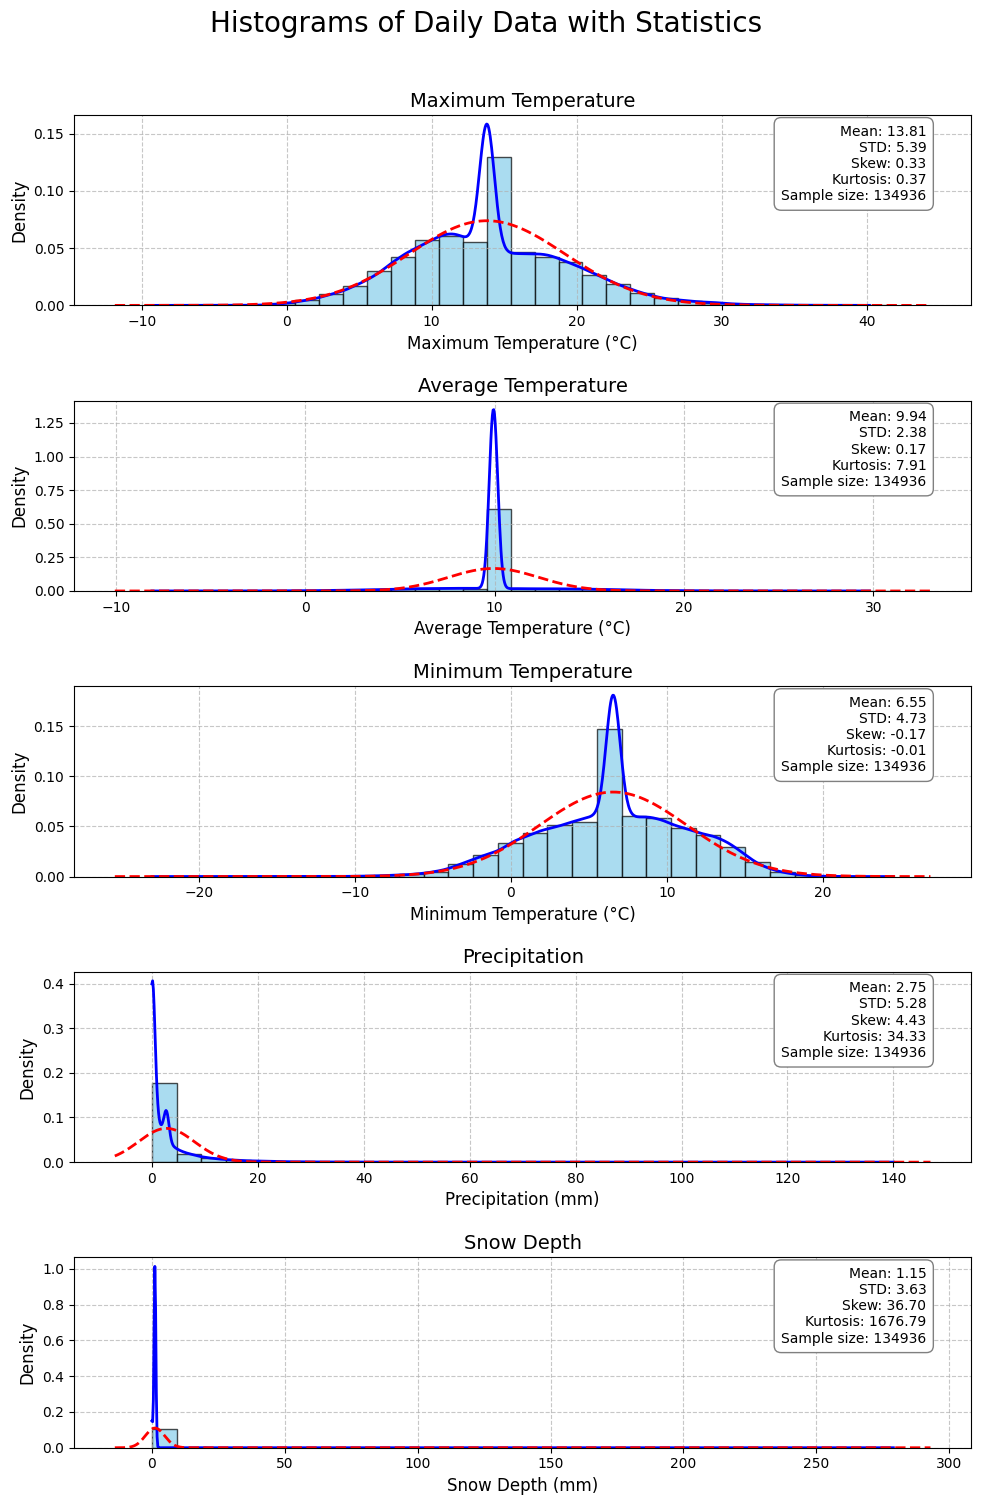

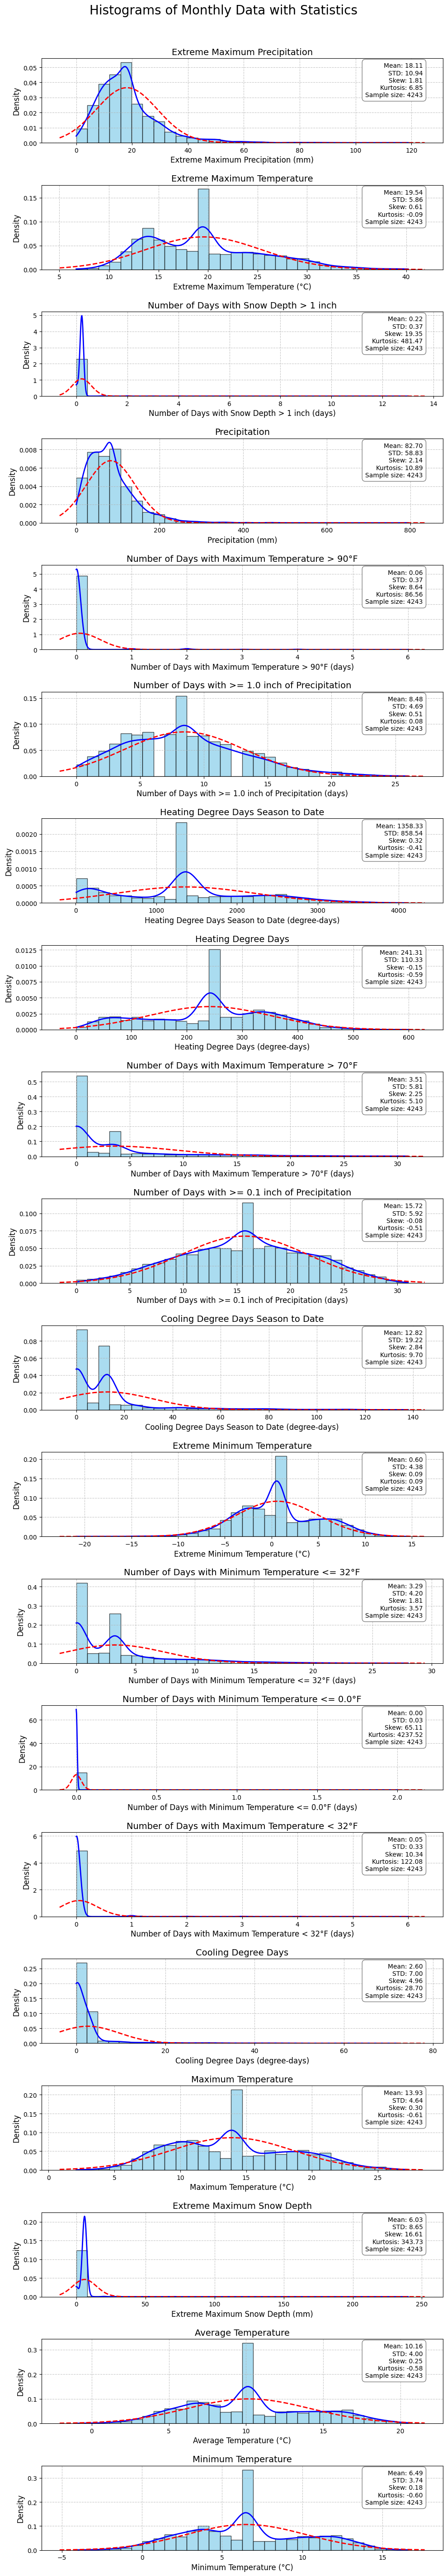

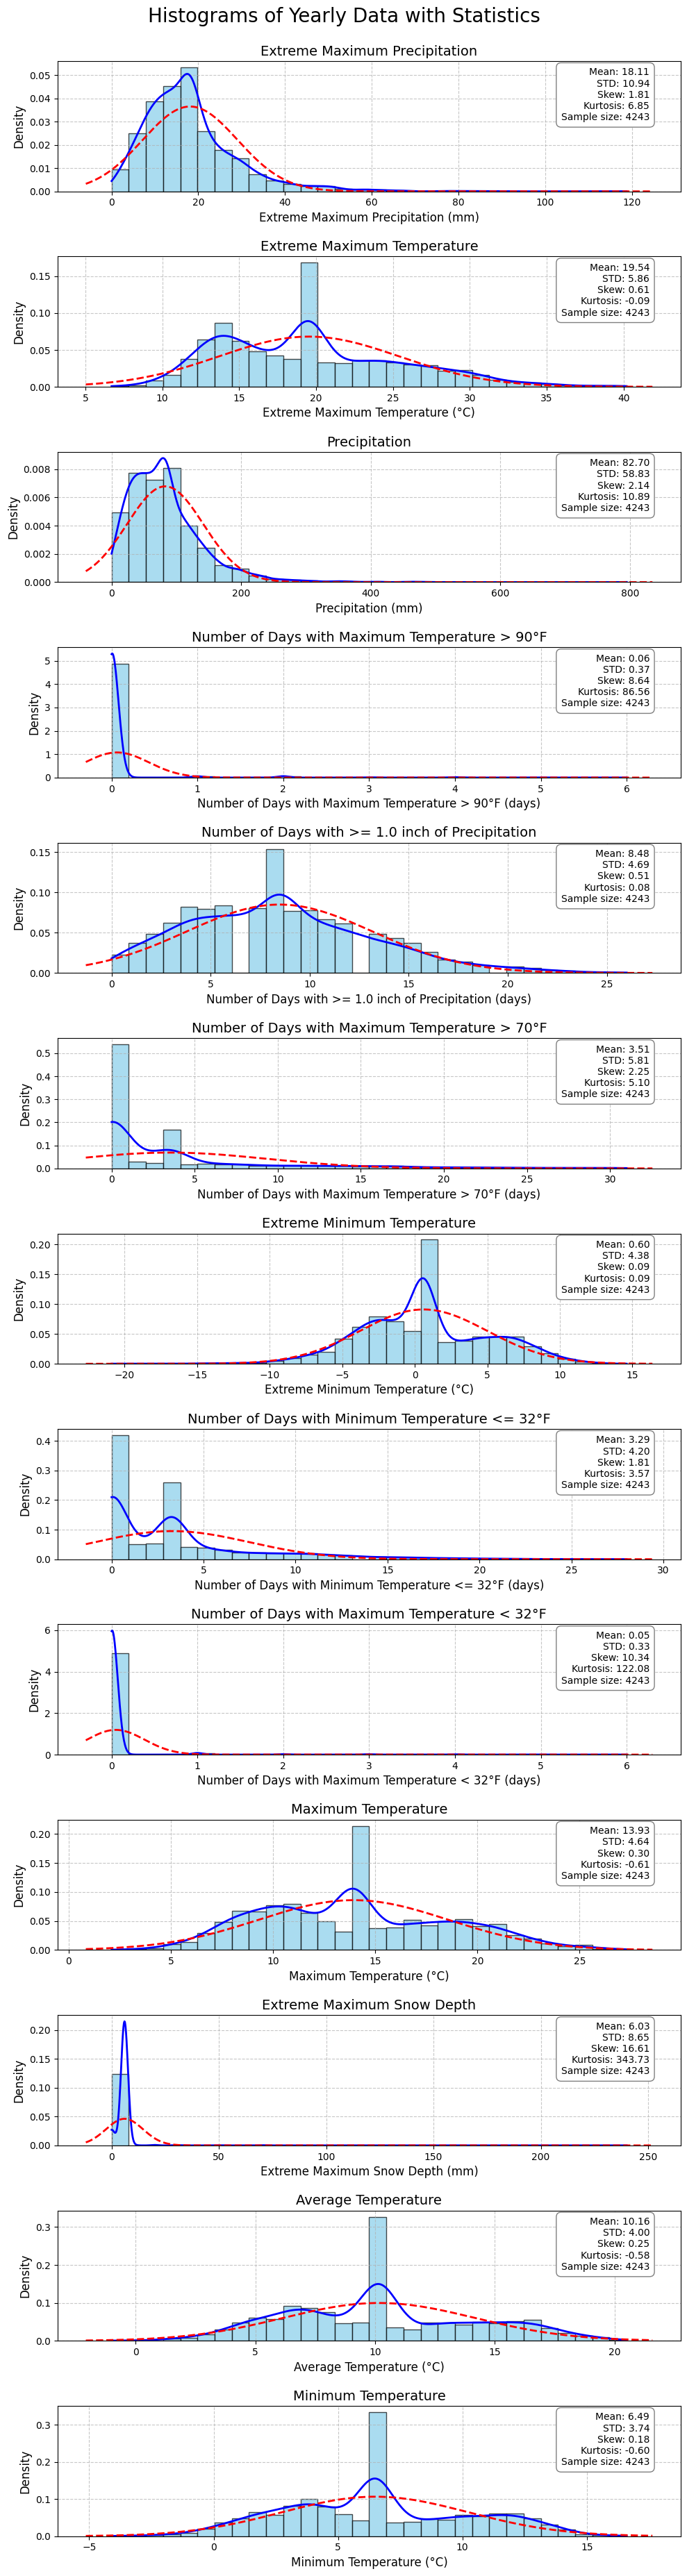

In [12]:
def plot_histograms_with_stats(df, name, cols, col_names, units, figsize, suptitle_y):
    num_rows = len(cols)
    fig, axes = plt.subplots(num_rows, 1, figsize=figsize, sharex=False)
    fig.suptitle(f'Histograms of {name} Data with Statistics', fontsize=20, y=suptitle_y)

    for i, (col, col_name, unit) in enumerate(zip(cols, col_names, units)):
        data = pd.to_numeric(df[col], errors='coerce').dropna()

        if not data.empty:
            ax = axes[i]

            # Histogram and KDE
            bin_width = (data.max() - data.min()) / 30  # Adjust the number of bins for better visualization
            bins = np.arange(data.min(), data.max() + bin_width, bin_width)
            ax.hist(data, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')

            # Only compute KDE if there is more than one unique value
            if len(data.unique()) > 1:
                try:
                    kde = gaussian_kde(data)
                    x = np.linspace(data.min(), data.max(), 1000)
                    ax.plot(x, kde(x), color='blue')
                except Exception as e:
                    print(f"Skipping KDE for {col_name}: {e}")

            # Add bell curve (normal distribution)
            try:
                mean = data.mean()
                std_dev = data.std()
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 1000)
                p = norm.pdf(x, mean, std_dev)
                ax.plot(x, p, color='red', linestyle='dashed')
            except Exception as e:
                print(f"Skipping normal distribution fit for {col_name}: {e}")

            # Calculate statistics
            try:
                mean = data.mean()
                std_dev = data.std()
                skewness = skew(data)
                kurt = kurtosis(data)
                sample_size = len(data)

                # Add statistics to the plot
                stats_text = (f'Mean: {mean:.2f}\n'
                              f'STD: {std_dev:.2f}\n'
                              f'Skew: {skewness:.2f}\n'
                              f'Kurtosis: {kurt:.2f}\n'
                              f'Sample size: {sample_size}')
                ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                        verticalalignment='top', horizontalalignment='right',
                        fontsize=10, bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
            except Exception as e:
                print(f"Error calculating statistics for {col_name}: {e}")

            ax.set_title(col_name, fontsize=14)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_xlabel(f'{col_name} ({unit})', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            ax.set_title(f"{col_name} - No Data Available")
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(top=0.93, hspace=0.5)
    plt.show()

# Plot histograms with statistics separately for each dataset
# Daily Data
daily_figsize = (10, len(COLUMNS['daily']) * 3)
plot_histograms_with_stats(daily_data, 'Daily', COLUMNS['daily'], COLUMN_NAMES['daily'], UNITS['daily'], daily_figsize, suptitle_y=1)

# Monthly Data
monthly_figsize = (10, len(COLUMNS['monthly']) * 3)
plot_histograms_with_stats(monthly_data, 'Monthly', COLUMNS['monthly'], COLUMN_NAMES['monthly'], UNITS['monthly'], monthly_figsize, suptitle_y=0.95)

# Yearly Data
yearly_figsize = (10, len(COLUMNS['yearly']) * 3)
plot_histograms_with_stats(yearly_data, 'Yearly', COLUMNS['yearly'], COLUMN_NAMES['yearly'], UNITS['yearly'], yearly_figsize, suptitle_y=0.95)


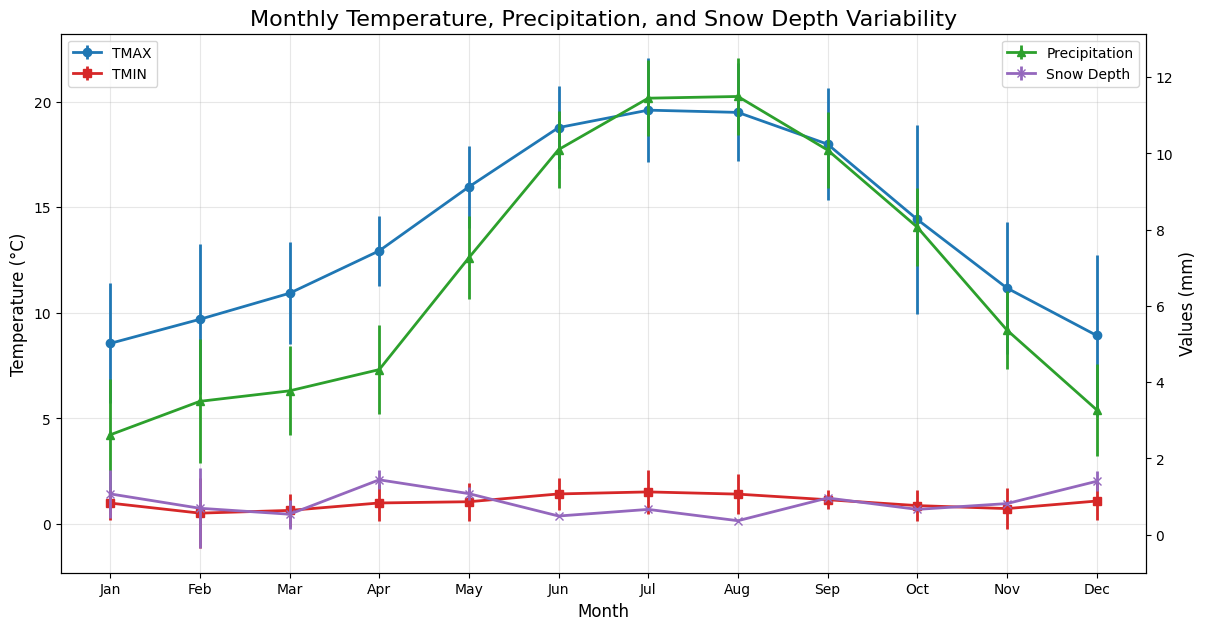

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to resample data and calculate statistics
def calculate_monthly_stats(df, columns):
    # Resample data to monthly data
    monthly_data = df[columns].resample('M').mean()

    # Extract month and year for grouping
    monthly_data['Year'] = monthly_data.index.year
    monthly_data['Month'] = monthly_data.index.month

    # Group by month and calculate mean and standard deviation
    monthly_stats = monthly_data.groupby('Month').agg({col: ['mean', 'std'] for col in columns})
    monthly_stats.columns = [f'{col}_mean' for col in columns] + [f'{col}_std' for col in columns]

    return monthly_stats

# Function to plot monthly variability for all parameters
def plot_combined_monthly_variability(stats, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    months = range(1, 13)
    ax1.errorbar(months, stats['TMAX_mean'], yerr=stats['TMAX_std'], fmt='-o', color='tab:blue', label='TMAX')
    ax1.errorbar(months, stats['TMIN_mean'], yerr=stats['TMIN_std'], fmt='-s', color='tab:red', label='TMIN')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.errorbar(months, stats['PRCP_mean'], yerr=stats['PRCP_std'], fmt='-^', color='tab:green', label='Precipitation')
    ax2.errorbar(months, stats['SNWD_mean'], yerr=stats['SNWD_std'], fmt='-x', color='tab:purple', label='Snow Depth')
    ax2.set_ylabel('Values (mm)')
    ax2.legend(loc='upper right')

    plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title(title)
    plt.show()

# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']
# Calculate monthly statistics
monthly_stats = calculate_monthly_stats(daily_data, columns)

# Plot combined monthly variability
plot_combined_monthly_variability(monthly_stats, 'Monthly Temperature, Precipitation, and Snow Depth Variability')


Yearly stats:
       TMAX_mean  TMAX_std  TMIN_mean  TMIN_std  PRCP_mean  PRCP_std  \
Year                                                                  
2020  13.820393       NaN   6.643413       NaN   3.058780       NaN   
2021  13.546887       NaN   6.338692       NaN   2.562568       NaN   
2022  14.559139       NaN   6.870333       NaN   2.320222       NaN   
2023  14.265720       NaN   7.006682       NaN   2.933643       NaN   
2024  10.429948       NaN   4.191961       NaN   3.151831       NaN   

      SNWD_mean  SNWD_std  
Year                       
2020   1.019867       NaN  
2021   1.249961       NaN  
2022   1.067772       NaN  
2023   1.117399       NaN  
2024   1.650507       NaN  


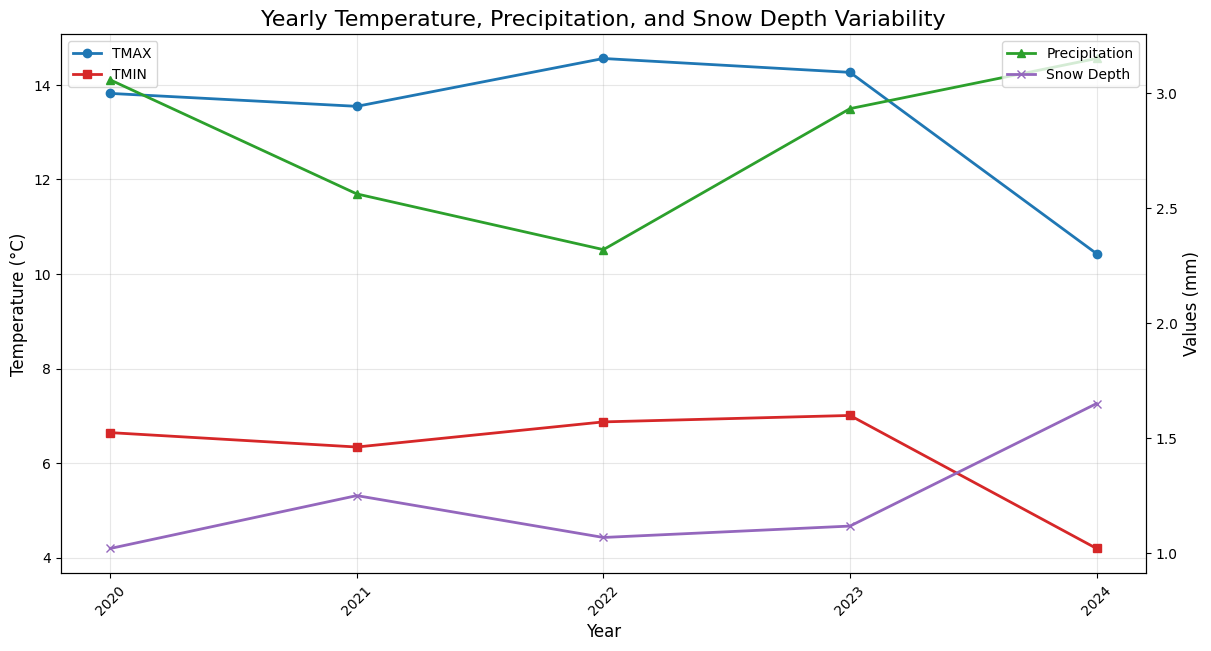

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to resample data and calculate yearly statistics
def calculate_yearly_stats(df, columns):
    # Resample data to yearly data
    yearly_data = df[columns].resample('Y').mean()

    # Extract year for grouping
    yearly_data['Year'] = yearly_data.index.year

    # Group by year and calculate mean and standard deviation
    yearly_stats = yearly_data.groupby('Year').agg(['mean', 'std'])
    yearly_stats.columns = ['_'.join(col) for col in yearly_stats.columns]

    return yearly_stats

# Function to plot yearly variability for all parameters
def plot_yearly_variability(stats, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    years = stats.index

    # Check if TMAX_mean or other required columns are not empty before plotting
    if not stats['TMAX_mean'].isnull().all():
        ax1.plot(years, stats['TMAX_mean'], '-o', color='tab:blue', label='TMAX')
        ax1.plot(years, stats['TMIN_mean'], '-s', color='tab:red', label='TMIN')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Temperature (°C)')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(years, stats['PRCP_mean'], '-^', color='tab:green', label='Precipitation')
        ax2.plot(years, stats['SNWD_mean'], '-x', color='tab:purple', label='Snow Depth')
        ax2.set_ylabel('Values (mm)')
        ax2.legend(loc='upper right')

        plt.title(title)

        # Set the x-axis to display one value per year
        ax1.set_xticks(years)
        ax1.set_xticklabels(years, rotation=45)

        plt.show()
    else:
        print("Error: No valid data to plot.")

# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']

# Fill NA values with the mean of each column
daily_data[columns] = daily_data[columns].apply(lambda x: x.fillna(x.mean()), axis=0)

# Calculate yearly statistics
yearly_stats = calculate_yearly_stats(daily_data, columns)

# Check for non-finite values and print the statistics for debugging
print("Yearly stats:\n", yearly_stats)

# Ensure all values are finite for plotting
yearly_stats = yearly_stats.replace([np.inf, -np.inf], np.nan)

# Check if the yearly_stats DataFrame is empty after cleaning
if yearly_stats.empty or yearly_stats[['TMAX_mean', 'TMIN_mean', 'PRCP_mean', 'SNWD_mean']].isnull().all().all():
    print("Error: The yearly_stats DataFrame is empty after removing non-finite values.")
else:
    # Plot yearly variability
    plot_yearly_variability(yearly_stats, 'Yearly Temperature, Precipitation, and Snow Depth Variability')


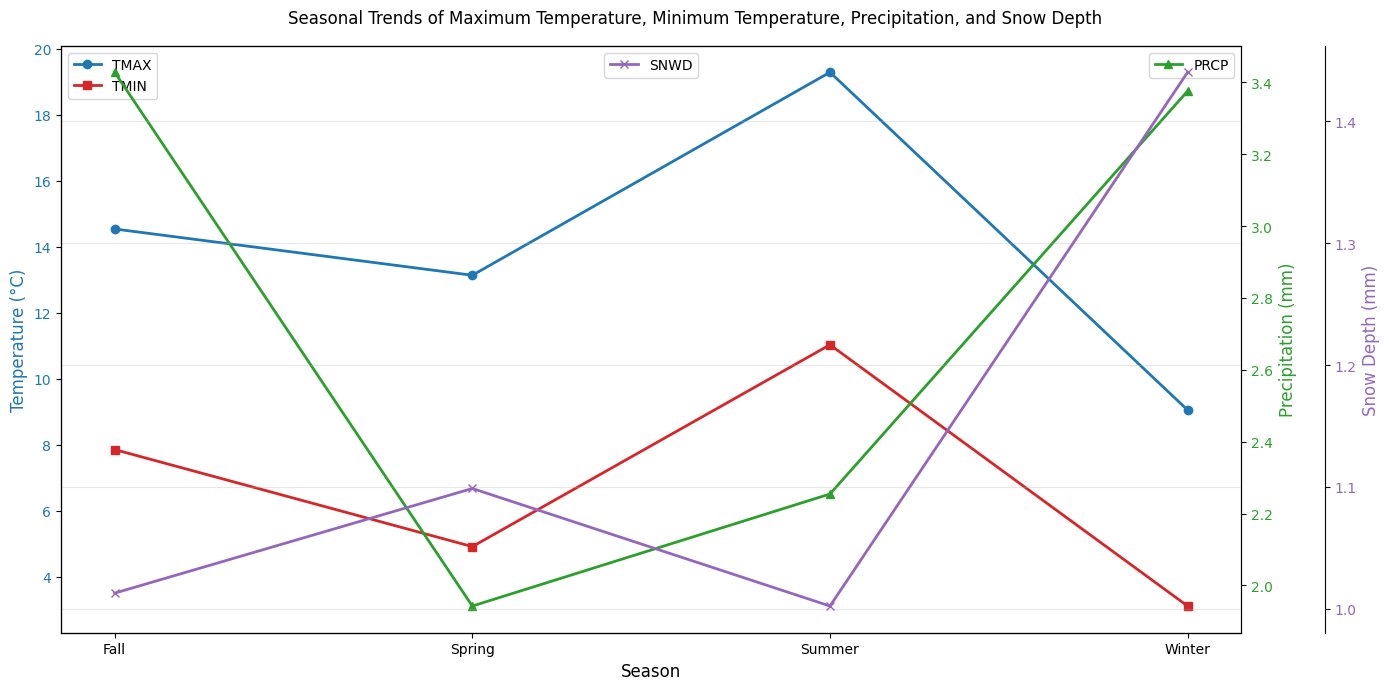

In [31]:
import matplotlib.pyplot as plt

# Function to categorize seasons
def categorize_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add season column to daily data
daily_data['Season'] = daily_data.index.map(categorize_season)

# Select only numeric columns before aggregation
daily_data_numeric = daily_data.select_dtypes(include=[np.number])
daily_data_numeric['Season'] = daily_data['Season']

# Aggregate data by season
seasonal_data = daily_data_numeric.groupby('Season').mean()

# Function to plot seasonal trends
def plot_seasonal_trends(df, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color1, color2, color3, color4 = 'tab:blue', 'tab:green', 'tab:red', 'tab:purple'

    ax1.set_xlabel('Season')
    ax1.set_ylabel('Temperature (°C)', color=color1)
    ax1.plot(df.index, df['TMAX'], color=color1, label='TMAX', marker='o')
    ax1.plot(df.index, df['TMIN'], color=color3, label='TMIN', marker='s')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Precipitation (mm)', color=color2)
    ax2.plot(df.index, df['PRCP'], color=color2, label='PRCP', marker='^')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Check if 'SNWD' column exists before plotting
    if 'SNWD' in df.columns:
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('Snow Depth (mm)', color=color4)
        ax3.plot(df.index, df['SNWD'], color=color4, label='SNWD', marker='x')
        ax3.tick_params(axis='y', labelcolor=color4)
        ax3.legend(loc='upper center')

    fig.suptitle(title)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Plot seasonal trends
plot_seasonal_trends(seasonal_data, 'Seasonal Trends of Maximum Temperature, Minimum Temperature, Precipitation, and Snow Depth')


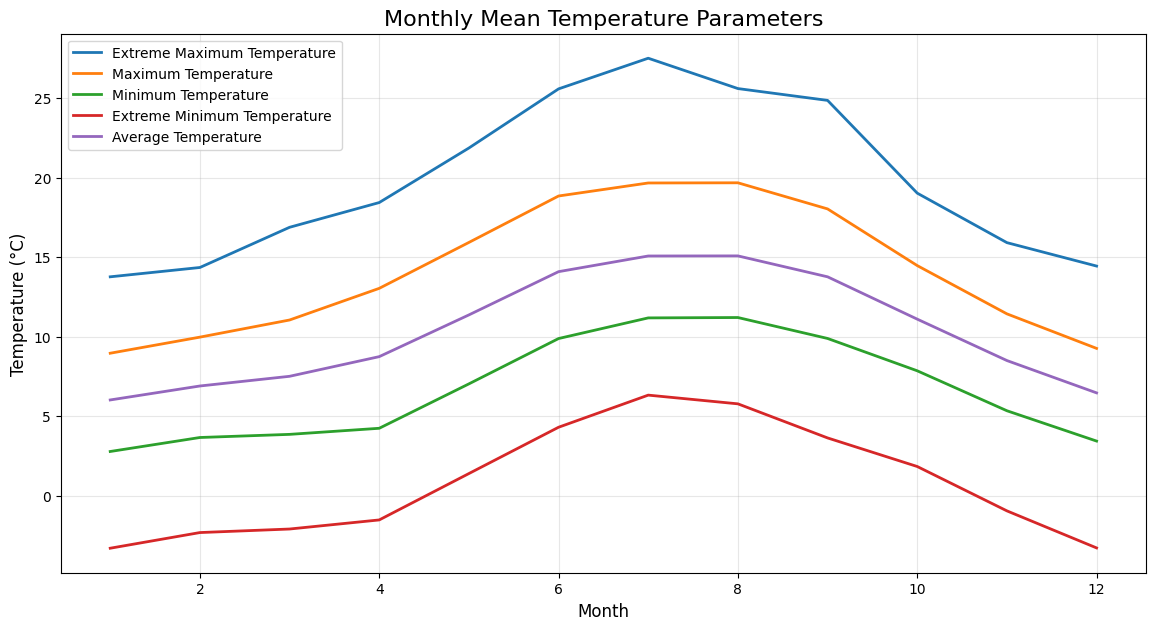

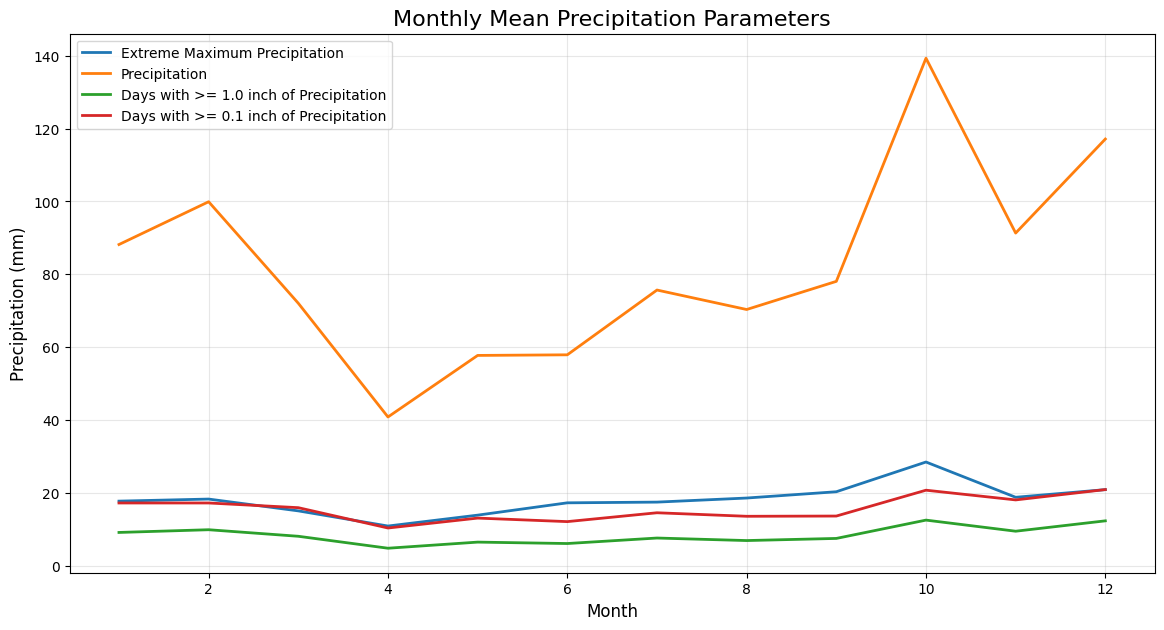

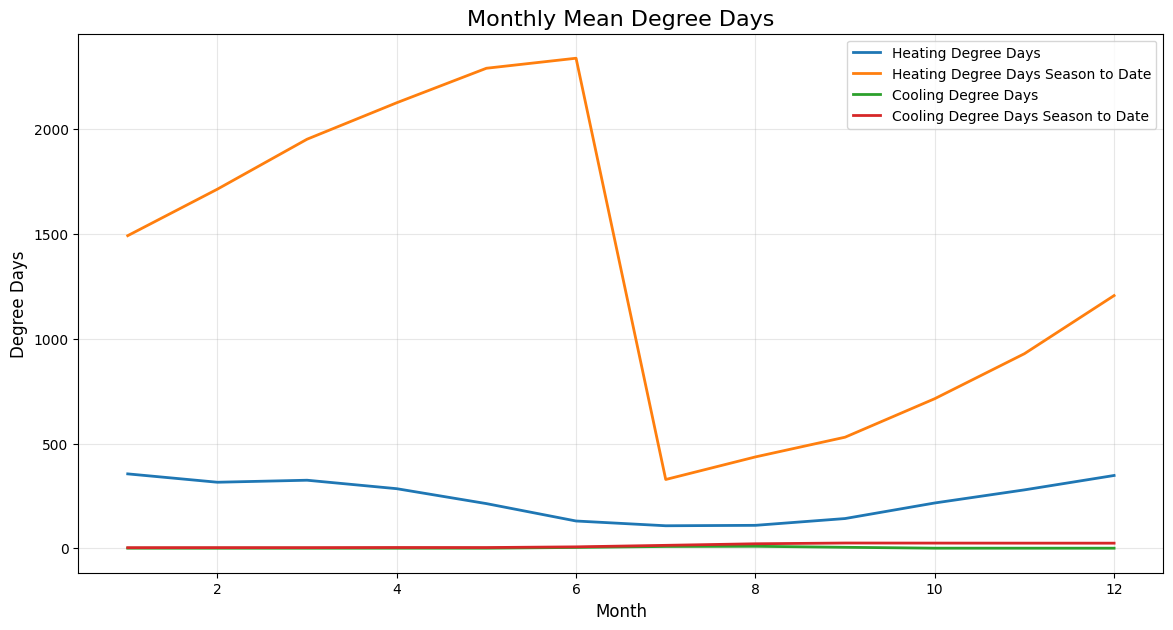

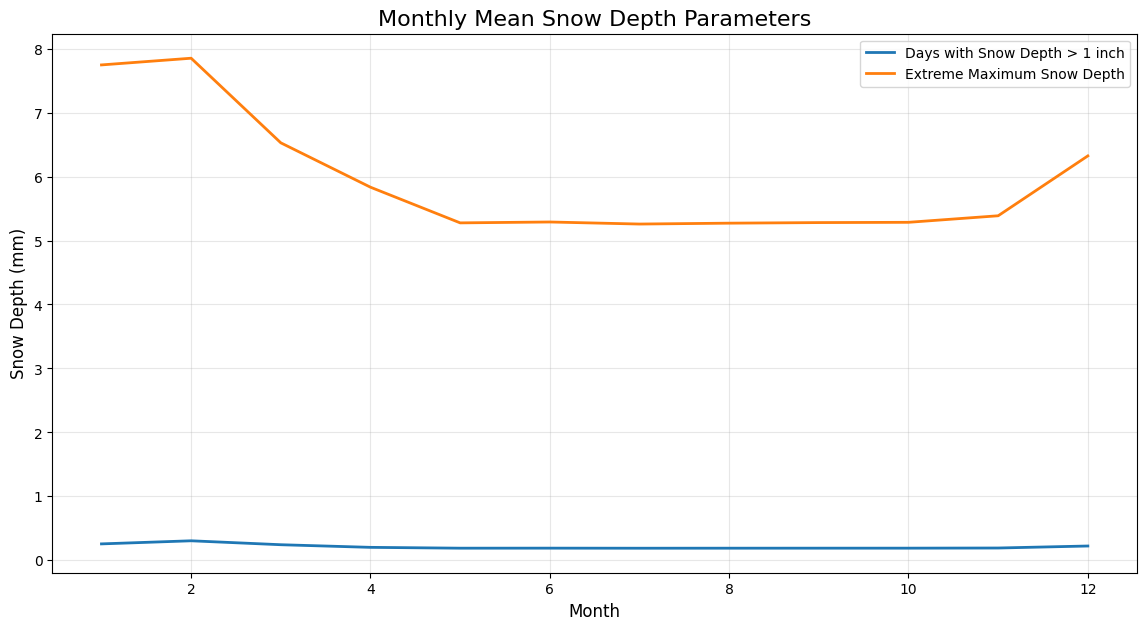

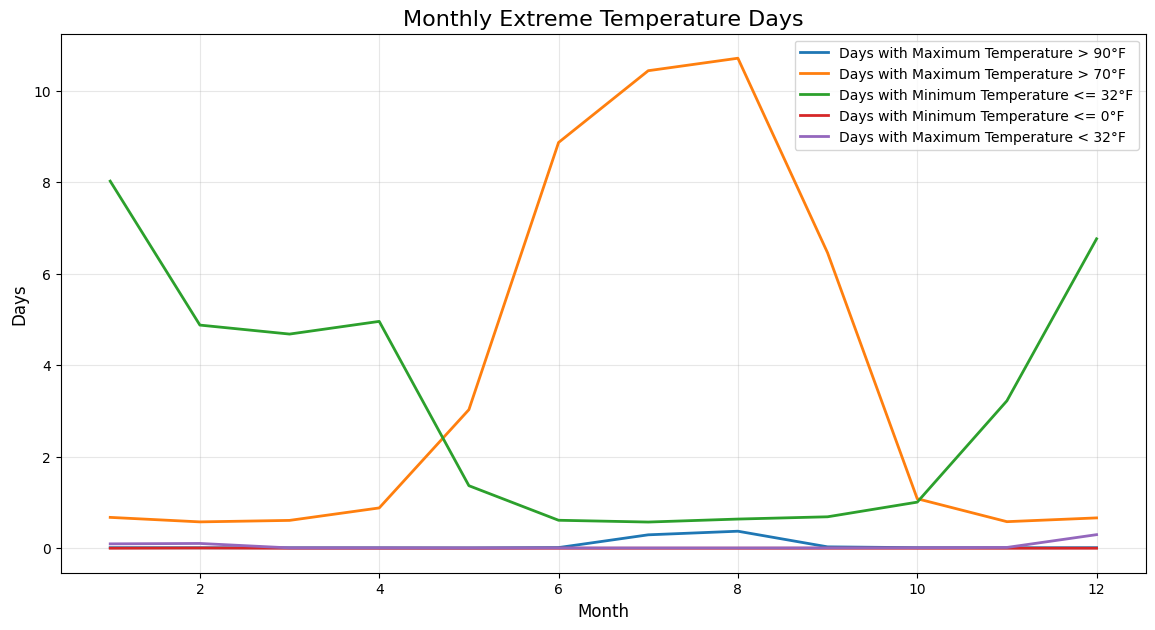

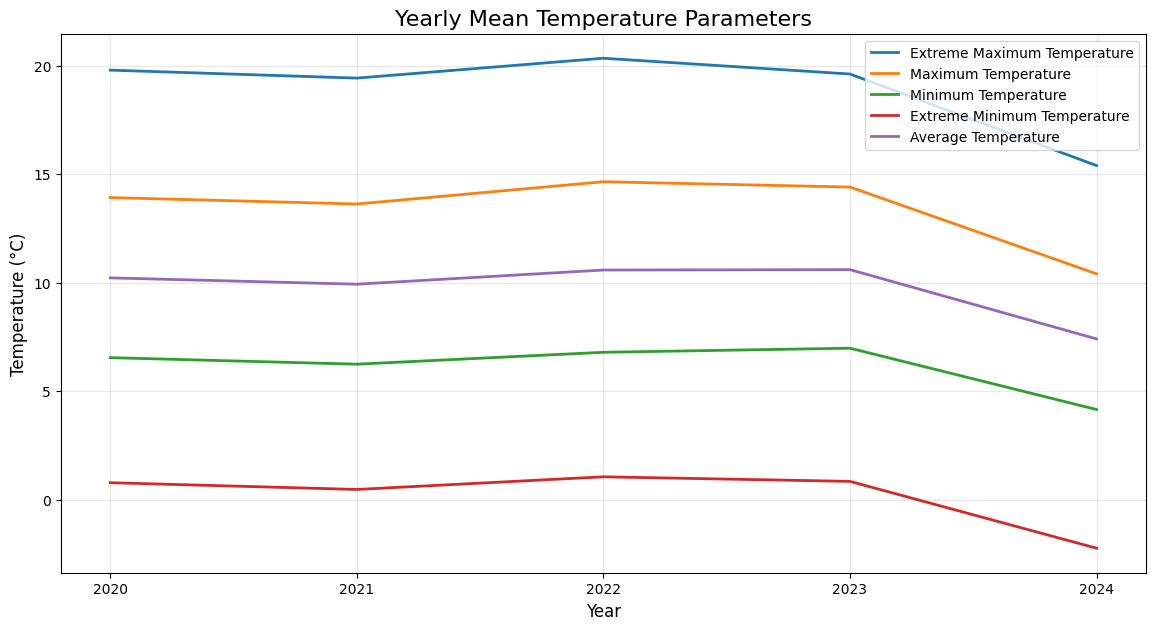

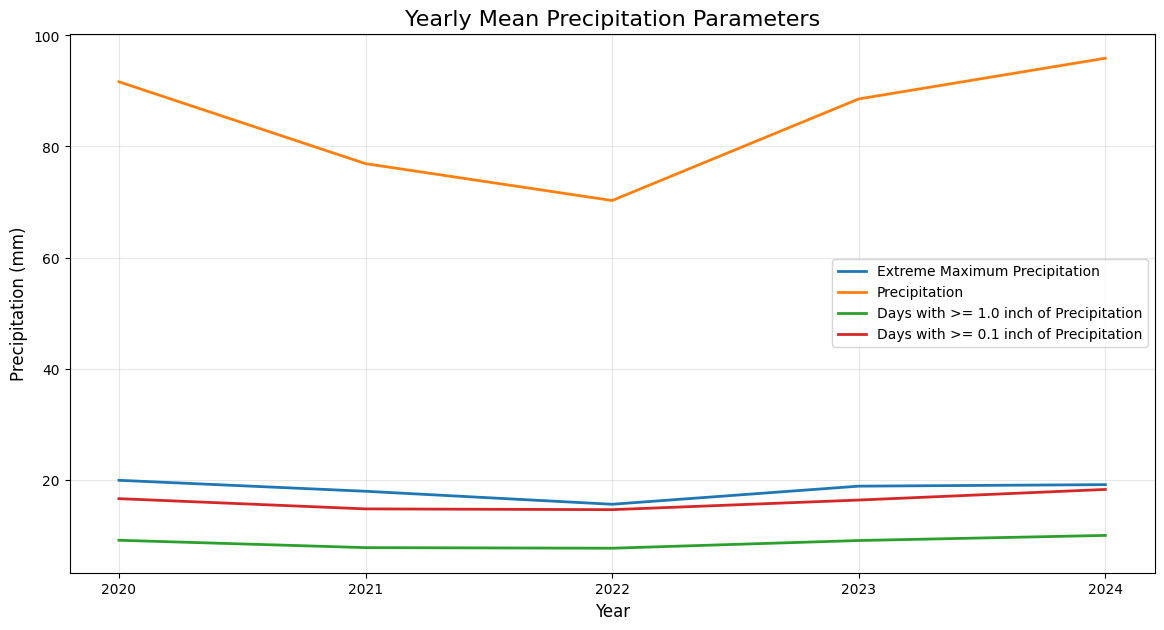

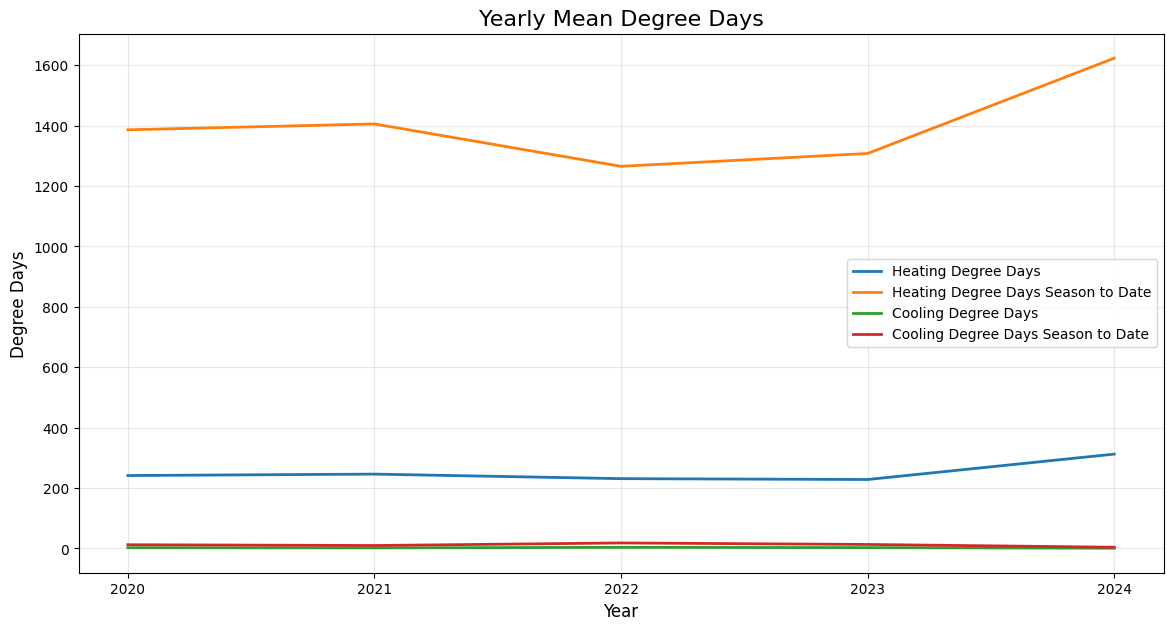

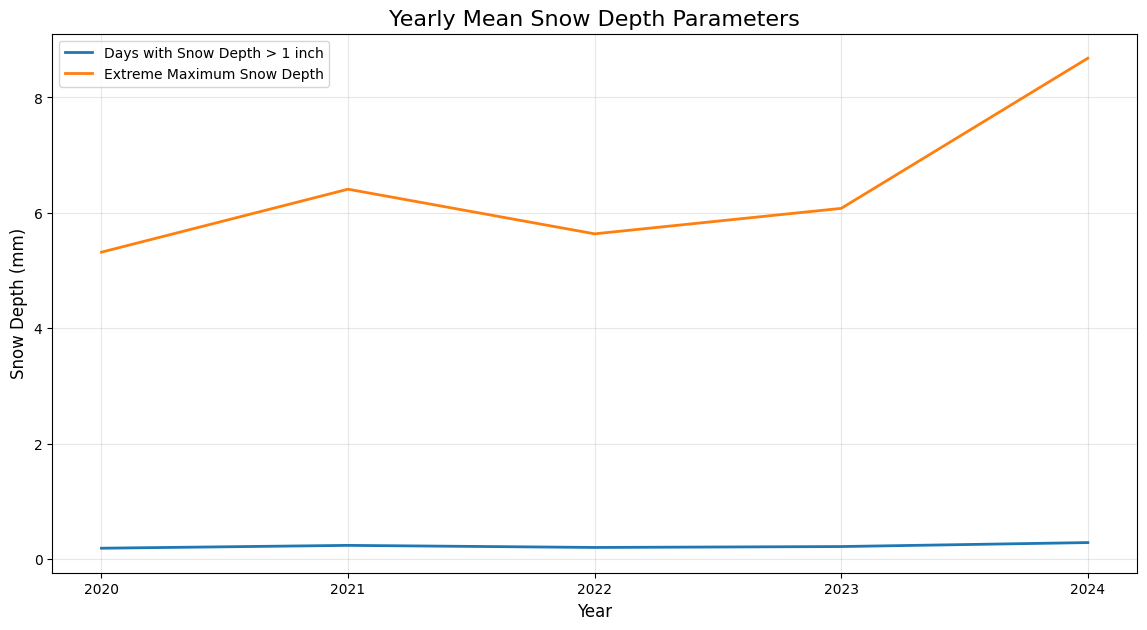

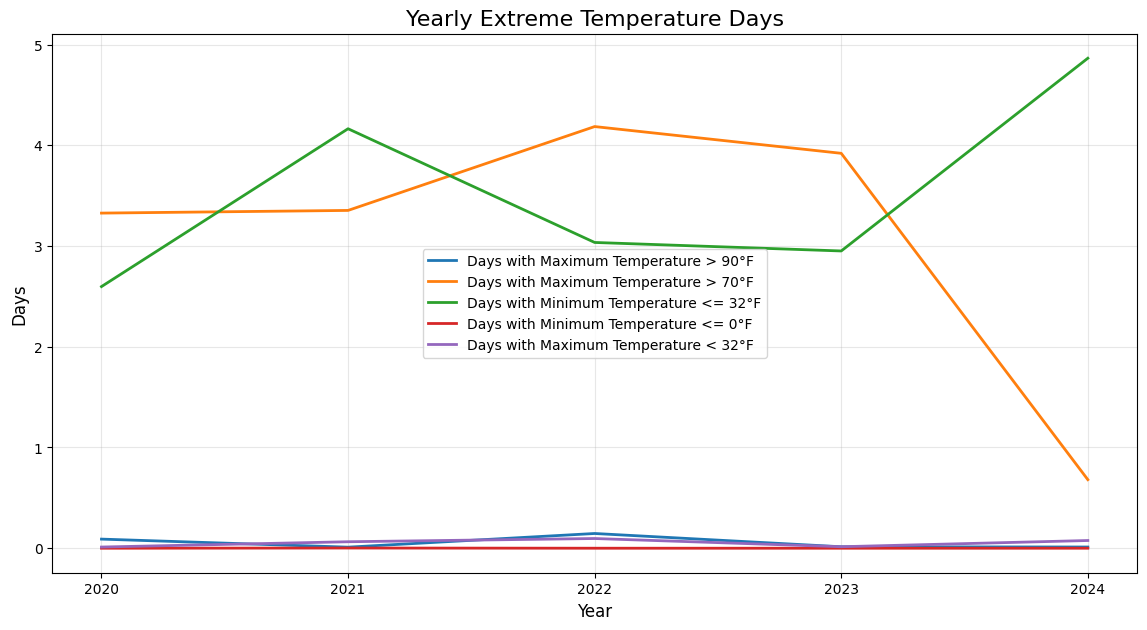

In [32]:
import matplotlib.pyplot as plt

# Function to plot grouped parameters with the option to specify frequency
def plot_grouped_parameters(df, params, param_full_names, title, y_label, frequency):
    plt.figure(figsize=(14, 7))
    for param, full_name in zip(params, param_full_names):
        if param in df.columns:
            plt.plot(df.index, df[param], label=full_name)
        else:
            print(f"Column {param} not found in the dataframe.")
    plt.xlabel('Year' if frequency == 'yearly' else 'Month')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if frequency == 'yearly':
        plt.xticks(df.index, df.index.astype(int))  # Set x-axis ticks to be the years
    plt.show()

# Grouped parameters and their full names
temp_params = ['EMXT', 'TMAX', 'TMIN', 'EMNT', 'TAVG']
temp_full_names = ['Extreme Maximum Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Extreme Minimum Temperature', 'Average Temperature']

precip_params = ['EMXP', 'PRCP', 'DP10', 'DP01']
precip_full_names = ['Extreme Maximum Precipitation', 'Precipitation', 'Days with >= 1.0 inch of Precipitation', 'Days with >= 0.1 inch of Precipitation']

degree_day_params = ['HTDD', 'HDSD', 'CLDD', 'CDSD']
degree_day_full_names = ['Heating Degree Days', 'Heating Degree Days Season to Date', 'Cooling Degree Days', 'Cooling Degree Days Season to Date']

snow_params = ['DSND', 'EMSD']
snow_full_names = ['Days with Snow Depth > 1 inch', 'Extreme Maximum Snow Depth']

extra_params = ['DX90', 'DX70', 'DT32', 'DT00', 'DX32']
extra_full_names = ['Days with Maximum Temperature > 90°F', 'Days with Maximum Temperature > 70°F', 'Days with Minimum Temperature <= 32°F', 'Days with Minimum Temperature <= 0°F', 'Days with Maximum Temperature < 32°F']

# Filter numeric columns for monthly and yearly data
monthly_numeric = monthly_data.select_dtypes(include='number')
yearly_numeric = yearly_data.select_dtypes(include='number')

# Group by month and year to calculate mean
monthly_grouped = monthly_numeric.groupby(monthly_numeric.index.month).mean()
yearly_grouped = yearly_numeric.groupby(yearly_numeric.index.year).mean()

# Plot grouped parameters by month
plot_grouped_parameters(monthly_grouped, temp_params, temp_full_names, 'Monthly Mean Temperature Parameters', 'Temperature (°C)', 'monthly')
plot_grouped_parameters(monthly_grouped, precip_params, precip_full_names, 'Monthly Mean Precipitation Parameters', 'Precipitation (mm)', 'monthly')
plot_grouped_parameters(monthly_grouped, degree_day_params, degree_day_full_names, 'Monthly Mean Degree Days', 'Degree Days', 'monthly')
plot_grouped_parameters(monthly_grouped, snow_params, snow_full_names, 'Monthly Mean Snow Depth Parameters', 'Snow Depth (mm)', 'monthly')
plot_grouped_parameters(monthly_grouped, extra_params, extra_full_names, 'Monthly Extreme Temperature Days', 'Days', 'monthly')

# Plot grouped parameters by year
plot_grouped_parameters(yearly_grouped, temp_params, temp_full_names, 'Yearly Mean Temperature Parameters', 'Temperature (°C)', 'yearly')
plot_grouped_parameters(yearly_grouped, precip_params, precip_full_names, 'Yearly Mean Precipitation Parameters', 'Precipitation (mm)', 'yearly')
plot_grouped_parameters(yearly_grouped, degree_day_params, degree_day_full_names, 'Yearly Mean Degree Days', 'Degree Days', 'yearly')
plot_grouped_parameters(yearly_grouped, snow_params, snow_full_names, 'Yearly Mean Snow Depth Parameters', 'Snow Depth (mm)', 'yearly')
plot_grouped_parameters(yearly_grouped, extra_params, extra_full_names, 'Yearly Extreme Temperature Days', 'Days', 'yearly')


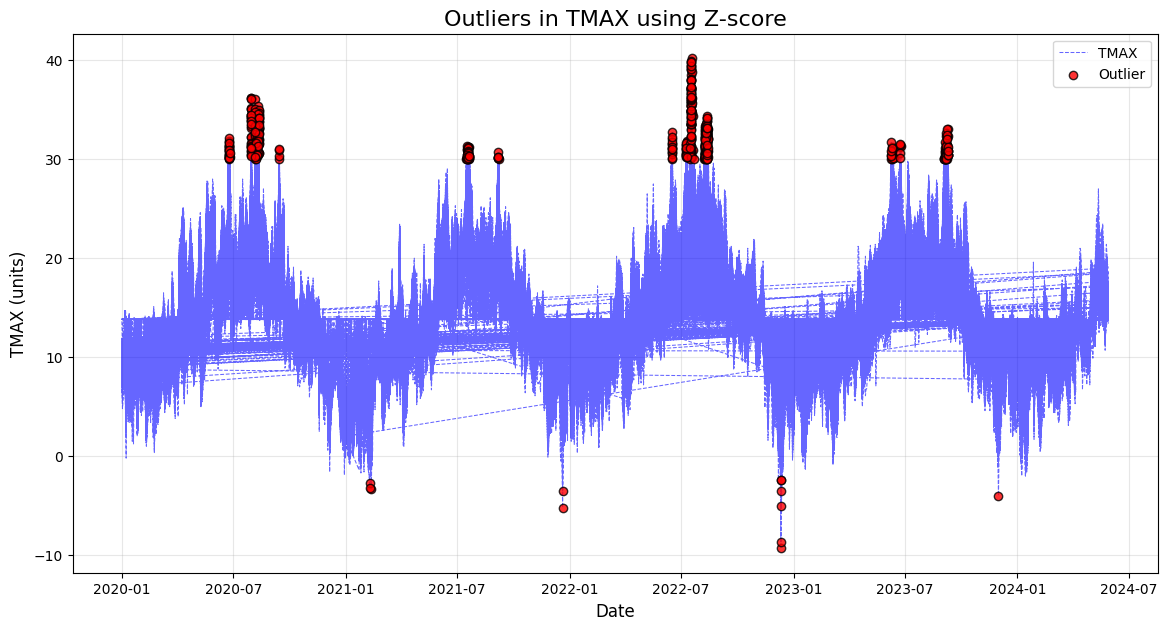

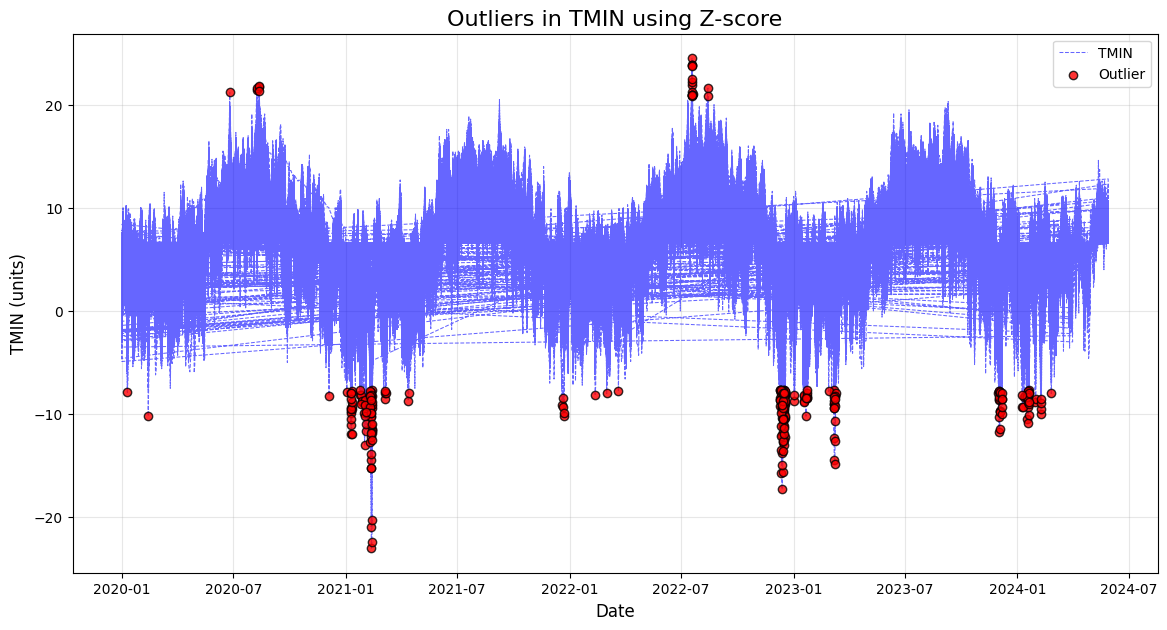

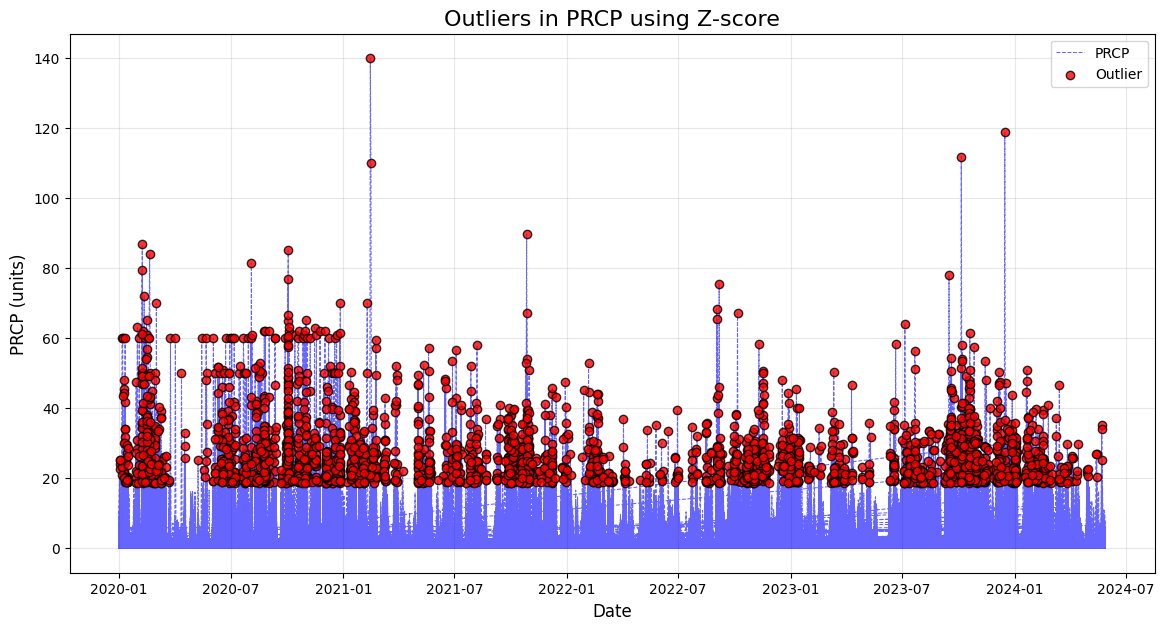

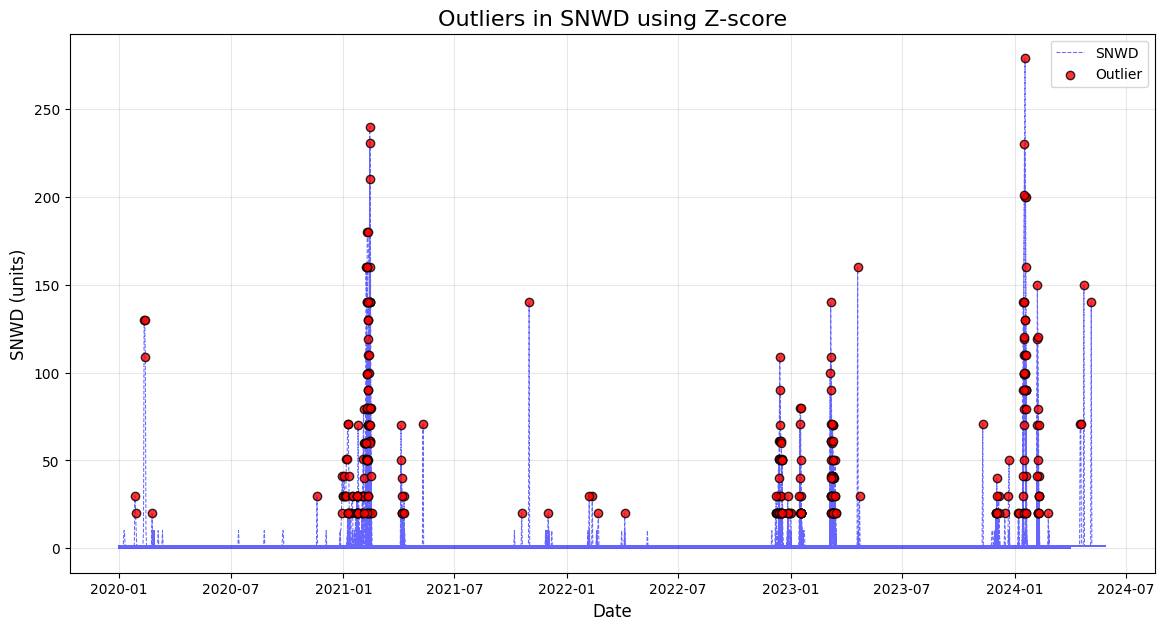

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Function to calculate Z-scores
def calculate_z_scores(df, column):
    df['Z_score'] = zscore(df[column])
    return df

# Function to detect outliers using Z-scores
def detect_outliers_z_score(df, column, threshold=3):
    df = calculate_z_scores(df, column)
    outliers = df[(df['Z_score'].abs() > threshold)]
    return outliers

# Function to plot outliers using Z-scores
def plot_outliers_z_score(df, outliers, column, title, y_label):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df.index, df[column], label=column, color='blue', linestyle='--', linewidth=0.75, alpha=0.6)
    ax.scatter(outliers.index, outliers[column], color='red', label='Outlier', edgecolor='k', zorder=5, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    plt.show()

# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']

# Detect and plot outliers using Z-scores for each column
for column in columns:
    outliers = detect_outliers_z_score(daily_data, column)
    plot_outliers_z_score(daily_data, outliers, column, f'Outliers in {column} using Z-score', f'{column} (units)')


Column: TMAX
Number of Outliers: 611
Mean of Outliers: 31.49
Standard Deviation of Outliers: 5.51
Minimum Outlier Value: -9.30
Maximum Outlier Value: 40.20


Column: TMIN
Number of Outliers: 296
Mean of Outliers: -7.29
Standard Deviation of Outliers: 8.56
Minimum Outlier Value: -23.00
Maximum Outlier Value: 24.50


Column: PRCP
Number of Outliers: 2982
Mean of Outliers: 27.47
Standard Deviation of Outliers: 10.45
Minimum Outlier Value: 18.60
Maximum Outlier Value: 140.00


Column: SNWD
Number of Outliers: 312
Mean of Outliers: 58.88
Standard Deviation of Outliers: 47.60
Minimum Outlier Value: 20.00
Maximum Outlier Value: 279.00




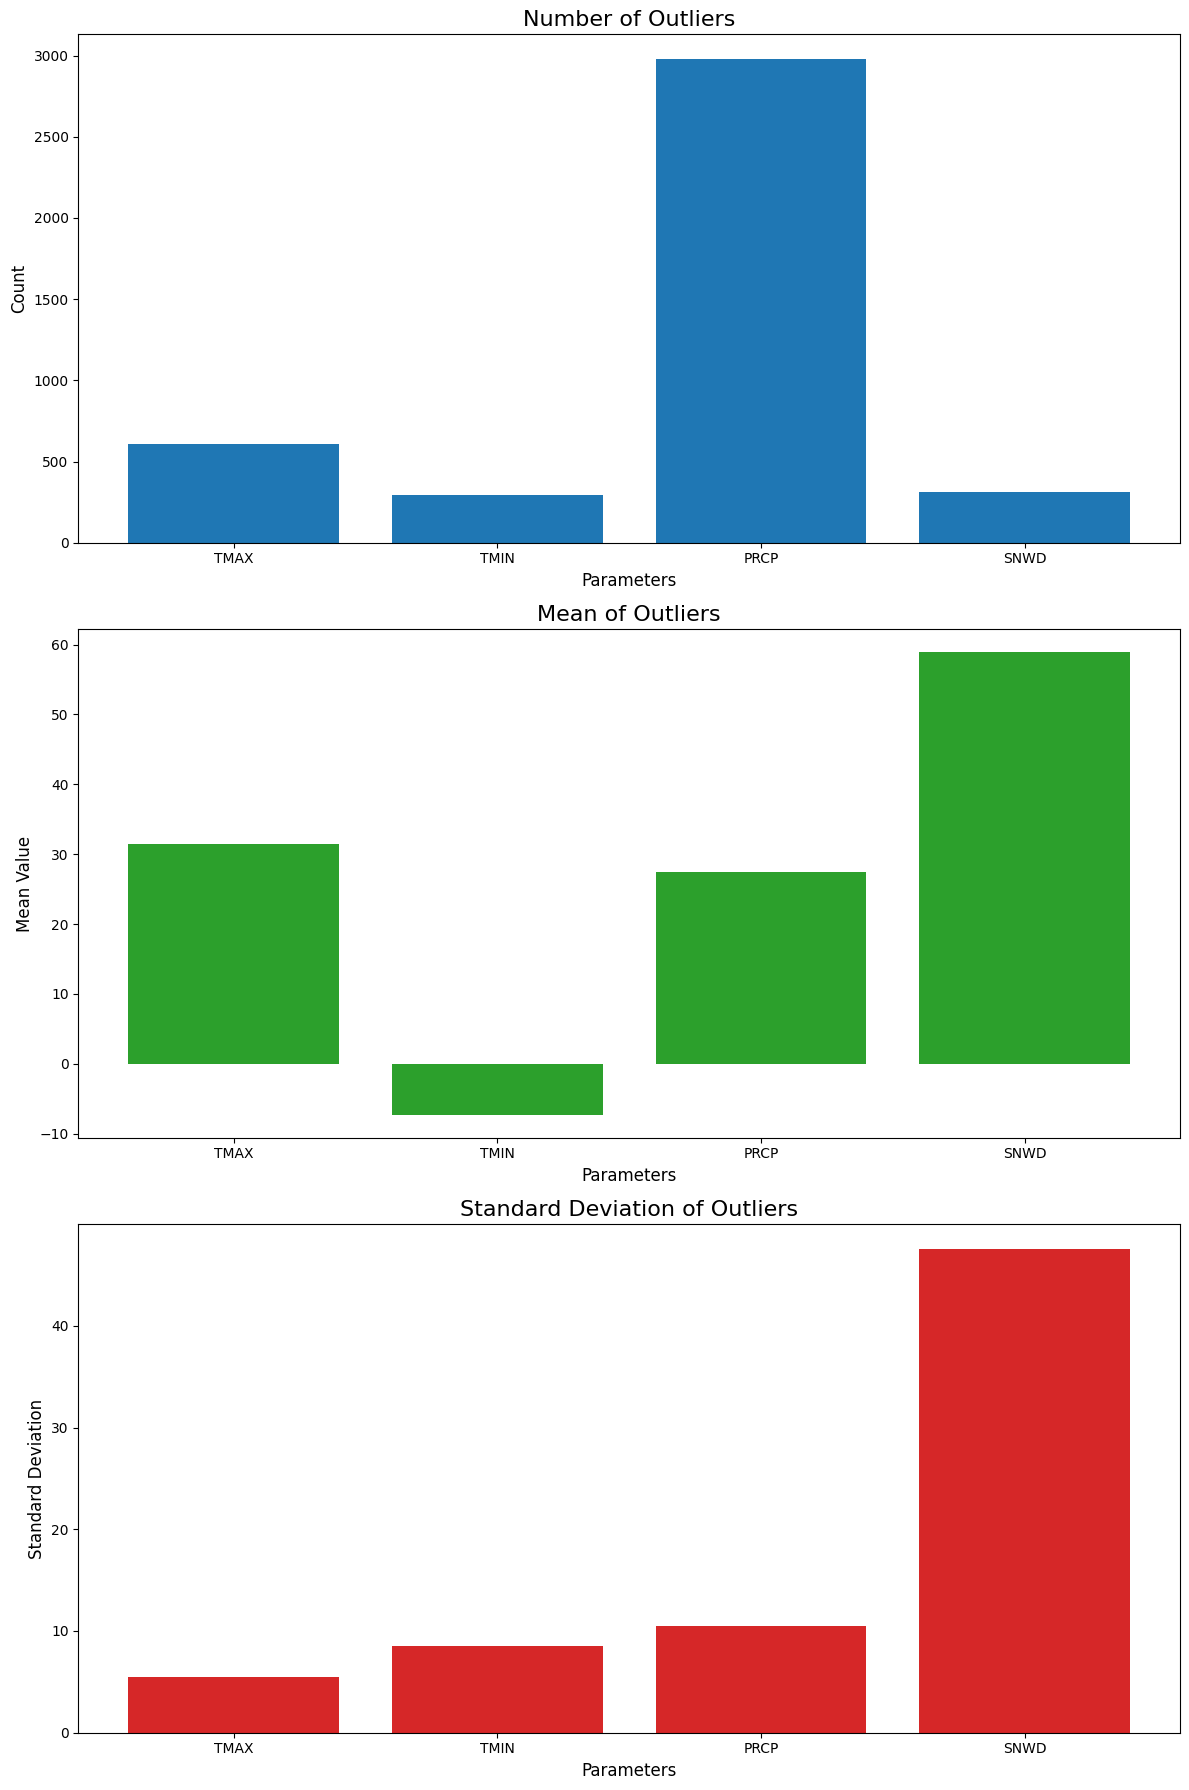

In [34]:
# Function to generate summary of outliers
def summarize_outliers(df, outliers, column):
    summary = {
        'column': column,
        'num_outliers': len(outliers),
        'mean_outliers': outliers[column].mean(),
        'std_outliers': outliers[column].std(),
        'min_outlier': outliers[column].min(),
        'max_outlier': outliers[column].max(),
    }
    return summary

# Function to print summary in a readable format
def print_outlier_summary(summary):
    print(f"Column: {summary['column']}")
    print(f"Number of Outliers: {summary['num_outliers']}")
    print(f"Mean of Outliers: {summary['mean_outliers']:.2f}")
    print(f"Standard Deviation of Outliers: {summary['std_outliers']:.2f}")
    print(f"Minimum Outlier Value: {summary['min_outlier']:.2f}")
    print(f"Maximum Outlier Value: {summary['max_outlier']:.2f}")
    print("\n")

# Function to visualize outlier summary using bar charts
def visualize_outlier_summary(summaries):
    columns = [summary['column'] for summary in summaries]
    num_outliers = [summary['num_outliers'] for summary in summaries]
    mean_outliers = [summary['mean_outliers'] for summary in summaries]
    std_outliers = [summary['std_outliers'] for summary in summaries]

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Number of Outliers
    axs[0].bar(columns, num_outliers, color='tab:blue')
    axs[0].set_title('Number of Outliers')
    axs[0].set_xlabel('Parameters')
    axs[0].set_ylabel('Count')

    # Mean of Outliers
    axs[1].bar(columns, mean_outliers, color='tab:green')
    axs[1].set_title('Mean of Outliers')
    axs[1].set_xlabel('Parameters')
    axs[1].set_ylabel('Mean Value')

    # Standard Deviation of Outliers
    axs[2].bar(columns, std_outliers, color='tab:red')
    axs[2].set_title('Standard Deviation of Outliers')
    axs[2].set_xlabel('Parameters')
    axs[2].set_ylabel('Standard Deviation')

    plt.tight_layout()
    plt.show()


# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']

# Detect, summarize, and display outliers for each column
outlier_summaries = []

for column in columns:
    outliers = detect_outliers_z_score(daily_data, column)
    summary = summarize_outliers(daily_data, outliers, column)
    outlier_summaries.append(summary)
    print_outlier_summary(summary)

# Visualize the outlier summary
visualize_outlier_summary(outlier_summaries)

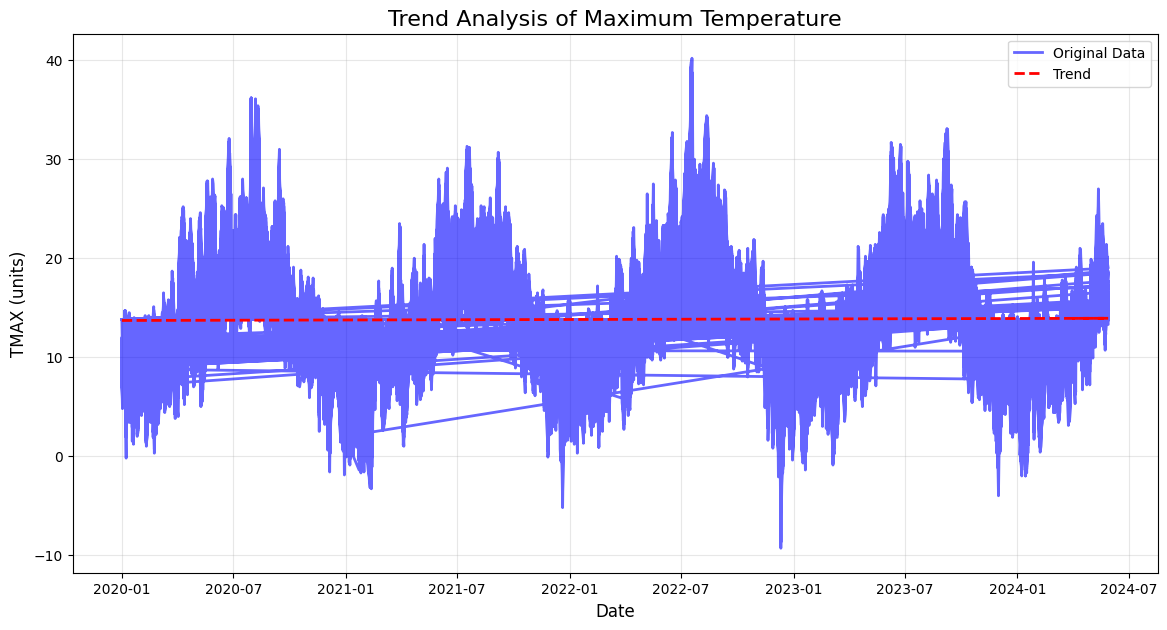

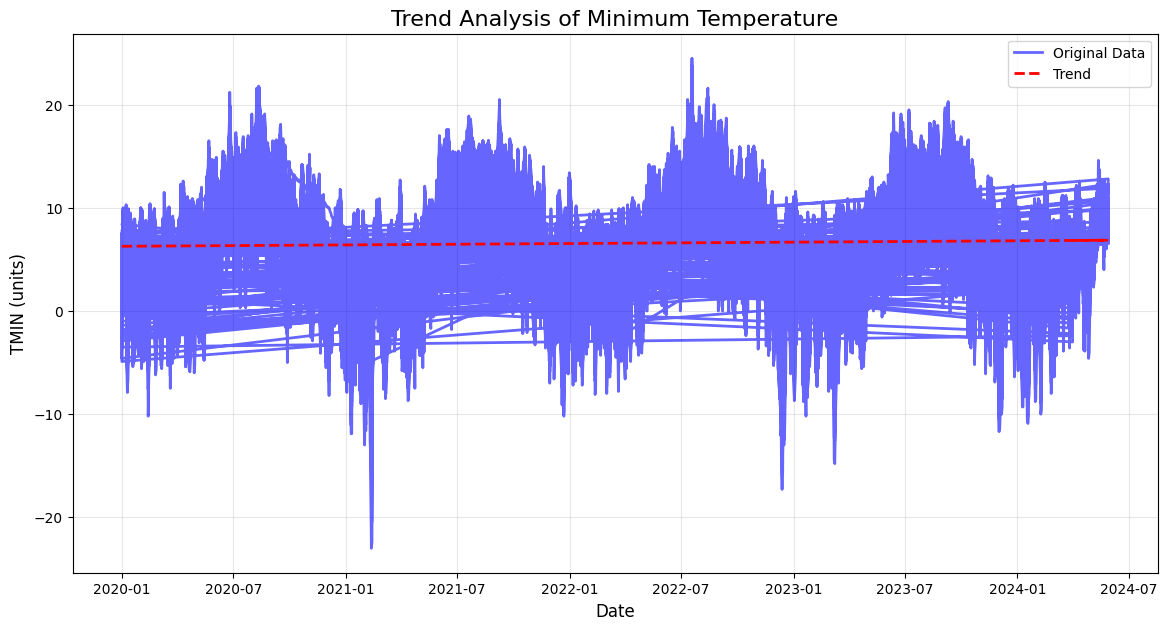

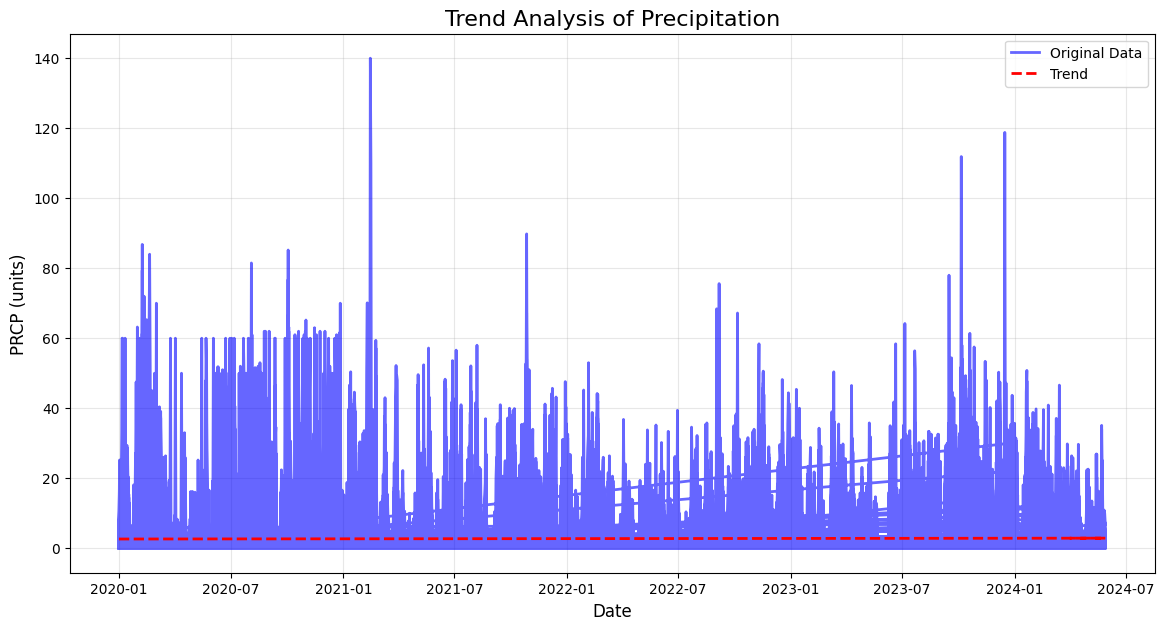

In [35]:
import numpy as np

# Function to perform trend analysis
def plot_trend_analysis(df, column, title):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plotting the original data
    ax.plot(df.index, df[column], label='Original Data', color='blue', alpha=0.6)

    # Calculating and plotting the trend
    z = np.polyfit(df.index.astype(np.int64) // 10**9, df[column], 1)
    p = np.poly1d(z)
    ax.plot(df.index, p(df.index.astype(np.int64) // 10**9), color='red', linestyle='--', linewidth=2, label='Trend')

    ax.set_title(f'Trend Analysis of {title}')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{column} (units)')
    ax.legend()
    ax.grid(True)
    plt.show()

# Perform trend analysis on temperature and precipitation
plot_trend_analysis(daily_data, 'TMAX', 'Maximum Temperature')
plot_trend_analysis(daily_data, 'TMIN', 'Minimum Temperature')
plot_trend_analysis(daily_data, 'PRCP', 'Precipitation')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps85sryrs/gm2qjfeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps85sryrs/h5s752hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30055', 'data', 'file=/tmp/tmps85sryrs/gm2qjfeo.json', 'init=/tmp/tmps85sryrs/h5s752hl.json', 'output', 'file=/tmp/tmps85sryrs/prophet_modelgewvox_f/prophet_model-20240718220108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


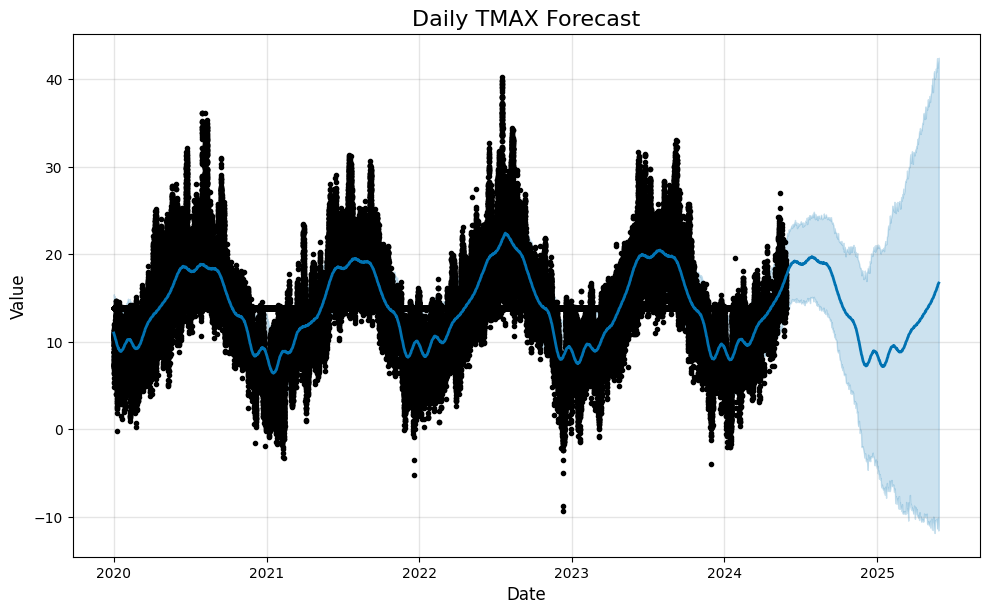

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps85sryrs/vvtsn1d4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps85sryrs/wo3fjbvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55501', 'data', 'file=/tmp/tmps85sryrs/vvtsn1d4.json', 'init=/tmp/tmps85sryrs/wo3fjbvh.json', 'output', 'file=/tmp/tmps85sryrs/prophet_model0i4x_8n2/prophet_model-20240718220318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


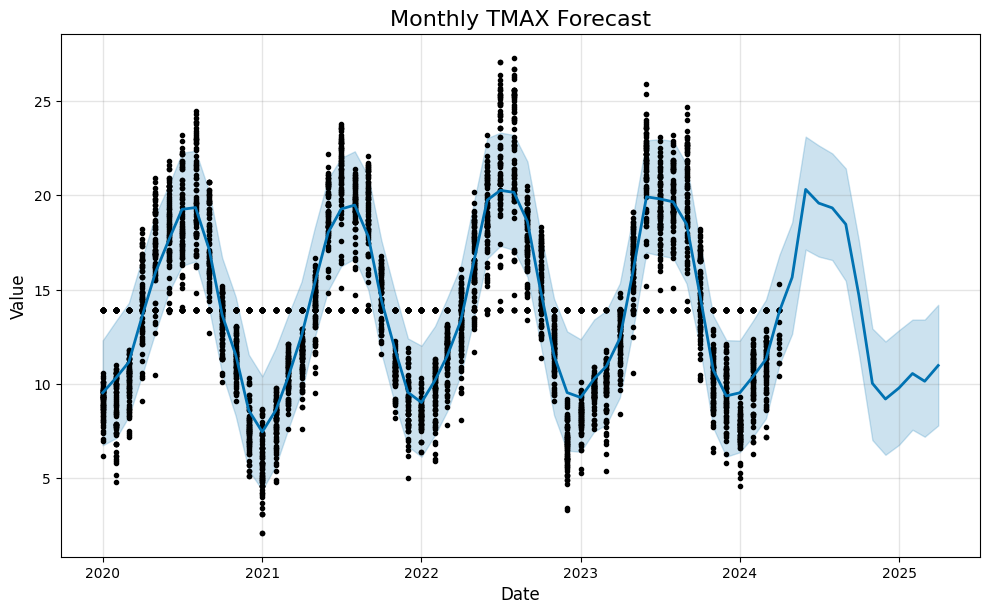

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps85sryrs/ygl22xcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps85sryrs/p7gauosl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43623', 'data', 'file=/tmp/tmps85sryrs/ygl22xcx.json', 'init=/tmp/tmps85sryrs/p7gauosl.json', 'output', 'file=/tmp/tmps85sryrs/prophet_model2v5ui2lp/prophet_model-20240718220321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


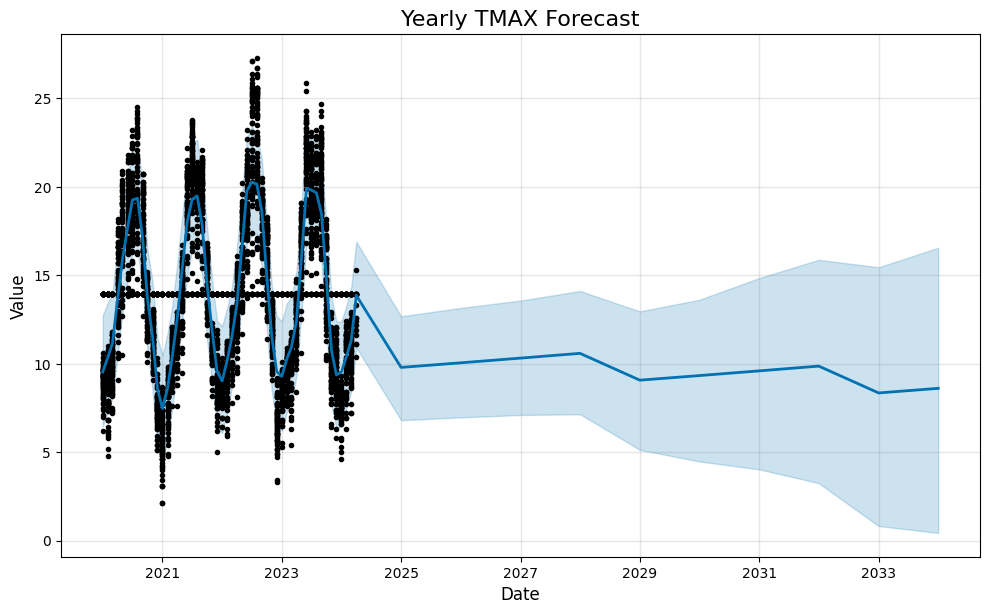

In [36]:
# Prepare data for Prophet
def prepare_prophet_data(df, column, date_column='DATE'):
    df = df.reset_index()  # Ensure index is not used for date column
    df[date_column] = pd.to_datetime(df[date_column])  # Ensure date column is in datetime format
    data = df[[date_column, column]].dropna().rename(columns={date_column: 'ds', column: 'y'})
    return data

# Function to fit and forecast using Prophet
def forecast_with_prophet(df, column, periods=365, freq='D'):
    data = prepare_prophet_data(df, column)
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    return model, forecast

# Plot the forecast
def plot_prophet_forecast(model, forecast, title):
    fig = model.plot(forecast)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

# Forecast and plot for daily, monthly, and yearly data
try:
    daily_model, daily_forecast = forecast_with_prophet(daily_data, 'TMAX')
    plot_prophet_forecast(daily_model, daily_forecast, 'Daily TMAX Forecast')
except Exception as e:
    print(f"Error forecasting daily TMAX: {e}")

try:
    monthly_model, monthly_forecast = forecast_with_prophet(monthly_data, 'TMAX', periods=12, freq='M')
    plot_prophet_forecast(monthly_model, monthly_forecast, 'Monthly TMAX Forecast')
except Exception as e:
    print(f"Error forecasting monthly TMAX: {e}")

try:
    yearly_model, yearly_forecast = forecast_with_prophet(yearly_data, 'TMAX', periods=10, freq='A')
    plot_prophet_forecast(yearly_model, yearly_forecast, 'Yearly TMAX Forecast')
except Exception as e:
    print(f"Error forecasting yearly TMAX: {e}")
